In [1]:
from velocity_plot import velocity_plot as vpl
from turtle import color
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from sampling import *
import pandas as pd
from colormap import *
import random
import os

In [2]:
def corr_coeff(ematrix, vmatrix, i):
    '''
    Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])
    '''
    # ematrix = cell_matrix
    # vmatrix = velocity_matrix
    ematrix = ematrix.T
    vmatrix = vmatrix.T
    ematrix = ematrix - ematrix[i, :]
    vmatrix = vmatrix[i, :][None, :]
    ematrix_m = ematrix - ematrix.mean(1)[:, None]
    vmatrix_m = vmatrix - vmatrix.mean(1)[:, None]

    # Sum of squares across rows
    ematrix_ss = (ematrix_m**2).sum(1)
    vmatrix_ss = (vmatrix_m**2).sum(1)
    cor = np.dot(ematrix_m, vmatrix_m.T) / \
        np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))
    return cor.T


def velocity_correlation(cell_matrix, velocity_matrix):
    """Calculate the correlation between the predict velocity (velocity_matrix[:,i])
    and the difference between a cell and every other (cell_matrix - cell_matrix[:, i])

    Arguments
    ---------
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    Return
    ---------
    c_matrix: np.ndarray (ncells, ncells)
    """
    c_matrix = np.zeros((cell_matrix.shape[1], velocity_matrix.shape[1]))
    for i in range(cell_matrix.shape[1]):
        c_matrix[i, :] = corr_coeff(cell_matrix, velocity_matrix, i)[0, :]
    
    
    np.fill_diagonal(c_matrix, 0)
    return c_matrix


def velocity_projection(cell_matrix, velocity_matrix, embedding, knn_embedding):
    '''
    cell_matrix: np.ndarray (ngenes, ncells)
        gene expression matrix
    velocity_matrix: np.ndarray (ngenes, ncells)
    '''
    # cell_matrix = np_s0[:,sampling_ixs]
    # velocity_matrix = np_dMatrix[:,sampling_ixs]
    
    sigma_corr = 0.05
    cell_matrix[np.isnan(cell_matrix)] = 0
    velocity_matrix[np.isnan(velocity_matrix)] = 0
    corrcoef = velocity_correlation(cell_matrix, velocity_matrix)
    probability_matrix = np.exp(corrcoef / sigma_corr)*knn_embedding.A
    probability_matrix /= probability_matrix.sum(1)[:, None]
    unitary_vectors = embedding.T[:, None, :] - embedding.T[:, :, None]
    with np.errstate(divide='ignore', invalid='ignore'):
        unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)
        np.fill_diagonal(unitary_vectors[0, ...], 0)
        np.fill_diagonal(unitary_vectors[1, ...], 0)
    velocity_embedding = (probability_matrix * unitary_vectors).sum(2)
    velocity_embedding -= (knn_embedding.A * unitary_vectors).sum(2) / \
        knn_embedding.sum(1).A.T  # embedding_knn.A *
    velocity_embedding = velocity_embedding.T
    
    return velocity_embedding, probability_matrix


def data_reshape(load_cellDancer):
    '''
    load detail file
    return expression matrix and velocity (ngenes, ncells)
    '''
    psc = 1
    gene_names = load_cellDancer['gene_name'].drop_duplicates().to_list()
    # cell_number = load_cellDancer[load_cellDancer['gene_name']==gene_names[0]].shape[0]
    # load_cellDancer['index'] = np.tile(range(cell_number),len(gene_names))
    load_cellDancer['index'] = 0
    for g in gene_names:
        load_cellDancer.loc[load_cellDancer['gene_name'] == g, 'index'] = range(
            load_cellDancer[load_cellDancer['gene_name'] == g].shape[0])
    s0_reshape = load_cellDancer.pivot(
        index='gene_name', values='s0', columns='index')
    s1_reshape = load_cellDancer.pivot(
        index='gene_name', values='s1', columns='index')
    dMatrix = s1_reshape-s0_reshape
    np_s0_reshape = np.array(s0_reshape)
    np_dMatrix = np.array(dMatrix)
    np_dMatrix2 = np.sqrt(np.abs(np_dMatrix) + psc) * \
        np.sign(np_dMatrix)  # (2159, 18140)
    return(np_s0_reshape, np_dMatrix2)


In [3]:
raw_data_path = "/Users/pengzhizhang/Documents/test_data/denGyr_full.csv"
load_raw_data = pd.read_csv(raw_data_path, names=[
                            'gene_list', 'u0', 's0', "clusters", 'cellID', 'embedding1', 'embedding2'])

detail_result_path = '/Users/pengzhizhang/Documents/test_data'
output_path = '/Users/pengzhizhang/Documents/test_data'

In [4]:
load_cellDancer = pd.read_csv('/Users/pengzhizhang/Documents/test_data/detail_e307.csv')

In [5]:
gene_choice=list(set(load_cellDancer.gene_name))
n_neighbors=100
add_amt_gene=10
data_df = load_raw_data[['gene_list', 'u0', 's0', 'cellID',
                             'embedding1', 'embedding2']][load_raw_data.gene_list.isin(gene_choice)]

random.seed(10)
embedding_downsampling, sampling_ixs, knn_embedding = downsampling_embedding(data_df,
                                                                            para='neighbors',
                                                                            target_amount=0,
                                                                            step_i=60,
                                                                            step_j=60,
                                                                            n_neighbors=n_neighbors)


neighbors


In [6]:
np_s0, np_dMatrix = data_reshape(load_cellDancer)  # 2min for 200 genes

np_dMatrix_all=np_dMatrix

np_s0_all=np_s0

In [7]:
embedding_df = load_raw_data[load_raw_data.gene_list == list(
    load_raw_data.gene_list[0])[0]][['embedding1', 'embedding2']]

embedding = embedding_df.to_numpy()

velocity_embedding, probability_matrix = velocity_projection(
    np_s0_all[:, sampling_ixs], np_dMatrix_all[:, sampling_ixs], embedding[sampling_ixs, :], knn_embedding)

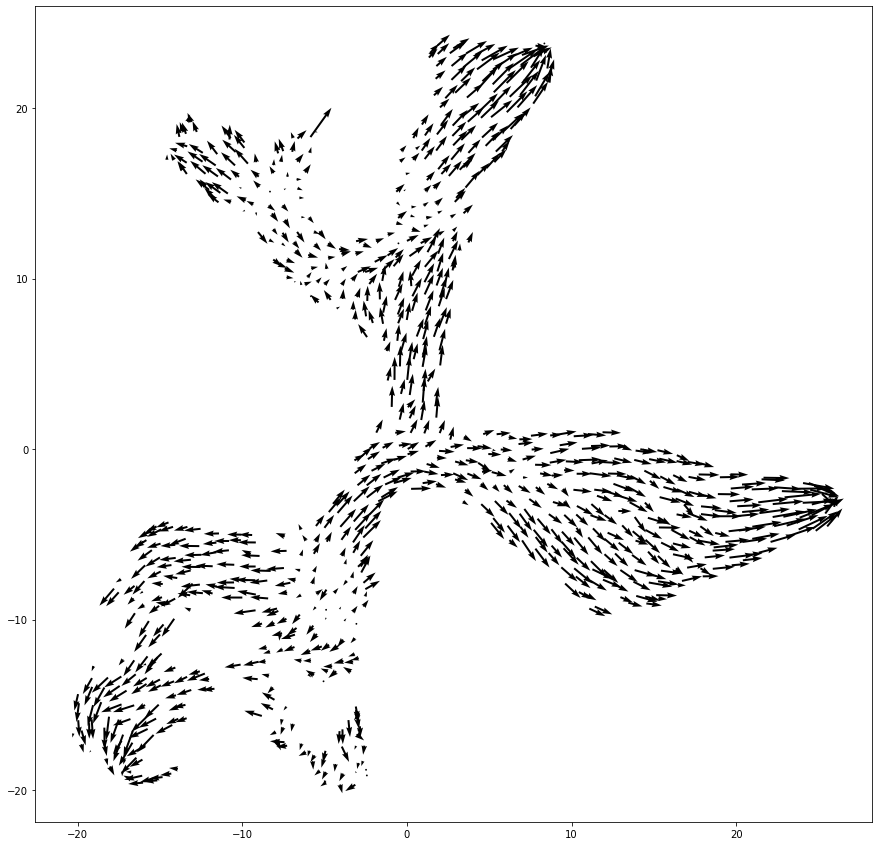

In [66]:
plt.rcParams["figure.figsize"] = (15,15)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1])

In [9]:
def gaussian_kernel(X, mu=0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [10]:
def compute_transition_matrix(prob_matrix, embedding, knn_embedding, mix_ratio=0.2):
    
    # sigma_D is set to the average distance between the closest neighbours
    X = pairwise_distances(embedding)
    
    X_temp = X + np.identity(X.shape[0])*X.max()
    near_dist = X_temp.min(axis=0)
    sigma_D = near_dist.mean()
    sigma_W = 0.5 * sigma_D
    W = gaussian_kernel(X, sigma=sigma_W)
    W /= W.sum(1)[:,None]
    
    D = prob_matrix * gaussian_kernel(X, sigma=sigma_D)
    np.fill_diagonal(D, D.max(1))
    D /= D.sum(1)[:,None]
    
    T = W*mix_ratio + D*(1-mix_ratio)
    T /= T.sum(1)[:,None]
    return T, W, D

In [150]:
embedding_lookup = load_raw_data.loc[embedding_downsampling.index]
embedding_lookup = embedding_lookup.drop_duplicates(subset='cellID')
#embedding_lookup = embedding_lookup.assign(down_sample_index = list(range(embedding_downsampling.shape[0])))

embedding_lookup = embedding_lookup.reset_index(drop=True)

In [178]:
def index(coordinate):
    em1,em2 = coordinate
    tol=0.5

    selected = embedding_lookup[((embedding_lookup.embedding1<em1+tol) & (embedding_lookup.embedding1>em1-tol) & (embedding_lookup.embedding2<em2+tol) & (embedding_lookup.embedding2>em2-tol))]
    return selected.index.to_list()

In [199]:
index([-10,15])

[178, 323]

In [143]:
transition_matrix, W, D = compute_transition_matrix(probability_matrix, 
                                              embedding_downsampling.to_numpy(), 
                                              knn_embedding, 
                                              0.2)

In [201]:
# normalize the velocity to (-1,1)
# allowing leeway 10%

lway = 1.0
velocity = velocity_embedding
(v1_max,v2_max) = velocity.max(axis=0)
(v1_min,v2_min) = velocity.min(axis=0)
velocity /= np.array([max(v1_max,-v1_min), max(v2_max, -v2_min)])
velocity /= lway

# normalize the coordinate to (-1,1)
cell_embedding = embedding_downsampling.to_numpy()
(x1_max,x2_max) = cell_embedding.max(axis=0)
(x1_min,x2_min) = cell_embedding.min(axis=0)
cell_embedding /= np.array([max(x1_max,-x1_min), max(x2_max, -x2_min)])
cell_embedding /= lway

In [198]:
# move with closest neighbours
def diffusion(cell_embedding, velocity, init, dt, timestep, n_neighbors, eps = 1e-3):
    
    
    '''
    Simulation of diffusion of cells in the velocity field
    - velocity of nearest cells (v_net) are used to calculate 
        the velocity of a point in the embedding space
    - init is the initial cell or initial position
    - dt is time step
    - timestep is total number of time steps
    - eps is the criterion to stop a trajectory before timestep (v_net < eps)
    - keep track of the density of the nearest grid.
    '''
    
    # normalize the velocity to make it [-100,100]
    velocity /= max(velocity.max(), -velocity.min())
    nn = NearestNeighbors(n_neighbors=n_neighbors, radius=1, n_jobs=8)
    nn.fit(cell_embedding)
    
    dist, ix1 =  nn.kneighbors(cell_embedding, 10)
    ave_nb_dist = dist.mean(0)
    ave_10_nb_dist = dist.mean(0)[-1]
    
   # This function is slow
   # Need to put position on the mesh grid --> vnet
    def compute_vnet(position):
        nbrs = nn.radius_neighbors(position[None,:], radius=ave_10_nb_dist, return_distance=False)
        if(nbrs[0].any() == 0):
            print("yikes, no neighbour")
            return np.array([0,0])
        return np.mean(np.array([velocity[i] for i in nbrs[0]]), axis = 0)
        
    x0 = cell_embedding[init]
    vnet = velocity[init]
    trajectory = [x0]
    for i in range(timestep):
        x = x0 + vnet*dt
        vnet = compute_vnet(x)
        trajectory.append(x)
        if np.linalg.norm(vnet) < eps:
            print("velocity at ", x, "is too small")
            print("trajectory stopped at time step: ", i)
            break
        #print(i, x, vnet)
        x0 = x

    return trajectory

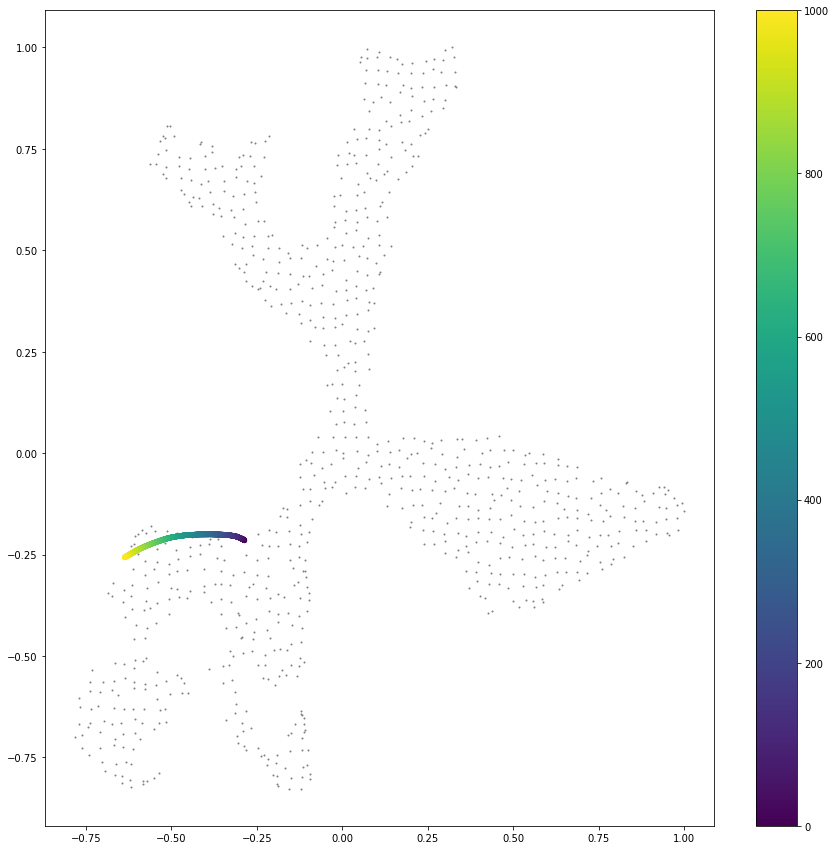

In [153]:
traj = diffusion(embedding_downsampling.to_numpy(),velocity_embedding, 0, 0.001, 1000, 10)
plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))
plt.colorbar()

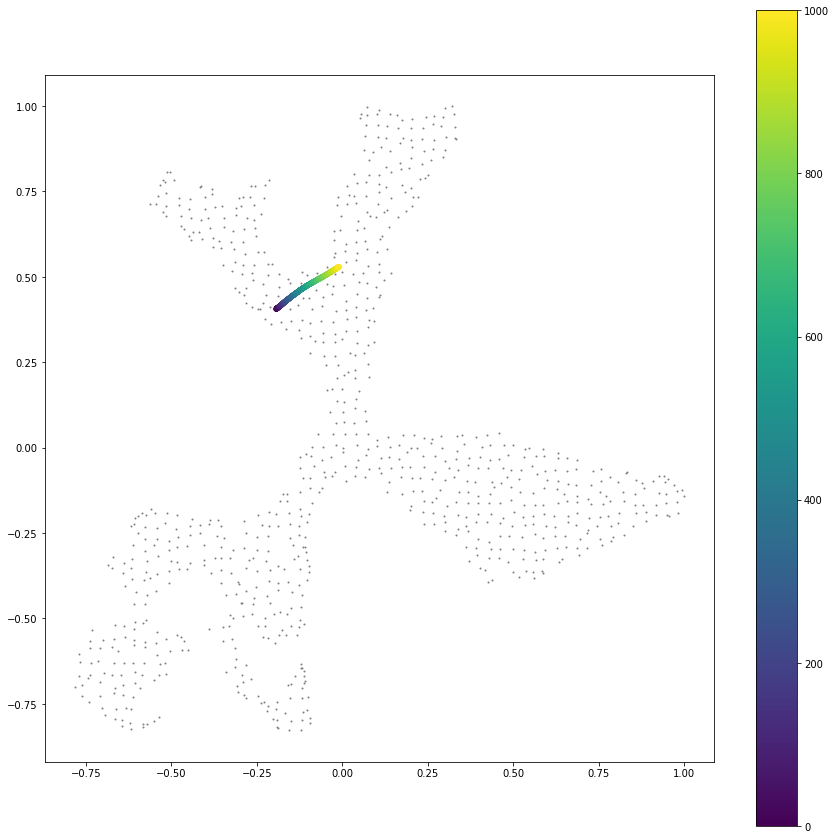

In [152]:
traj = diffusion(embedding_downsampling.to_numpy(),velocity_embedding, 334, 0.001, 1000, 100)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))

ax.set_aspect('equal', adjustable='box')

plt.colorbar()

yikes, no neighbour
velocity at  [-0.562285    0.84453651] is too small
trajectory stopped at time step:  1084


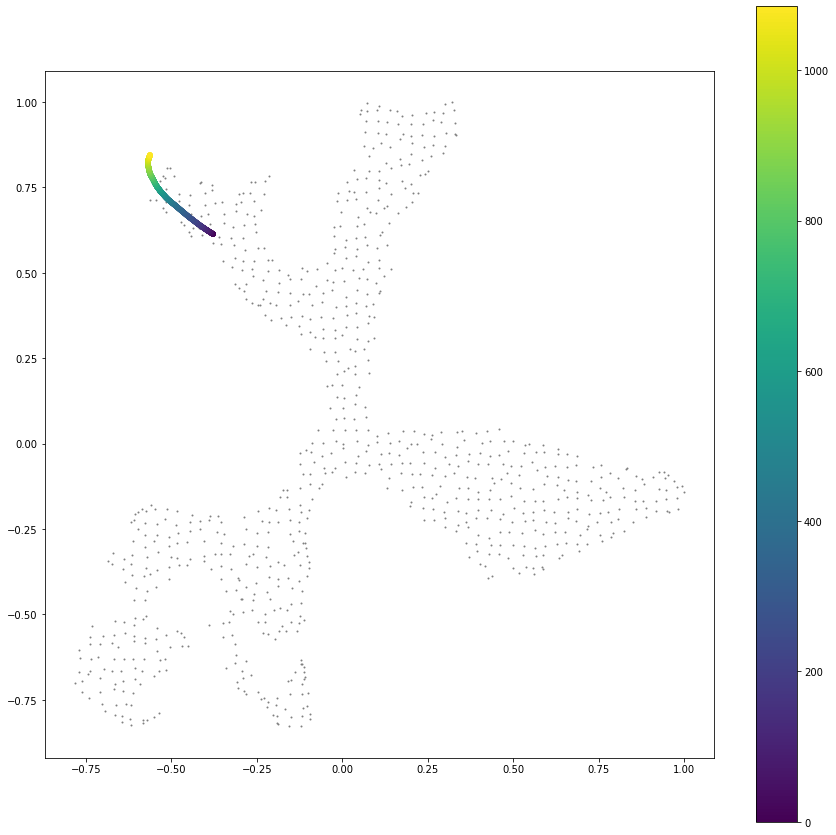

In [200]:
traj = diffusion(embedding_downsampling.to_numpy(),velocity_embedding, 178, 0.001, 2000, 100)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))

ax.set_aspect('equal', adjustable='box')

plt.colorbar()

yikes
velocity at  [-0.72379349 -0.87836631] is too small
trajectory stopped at time step:  1830


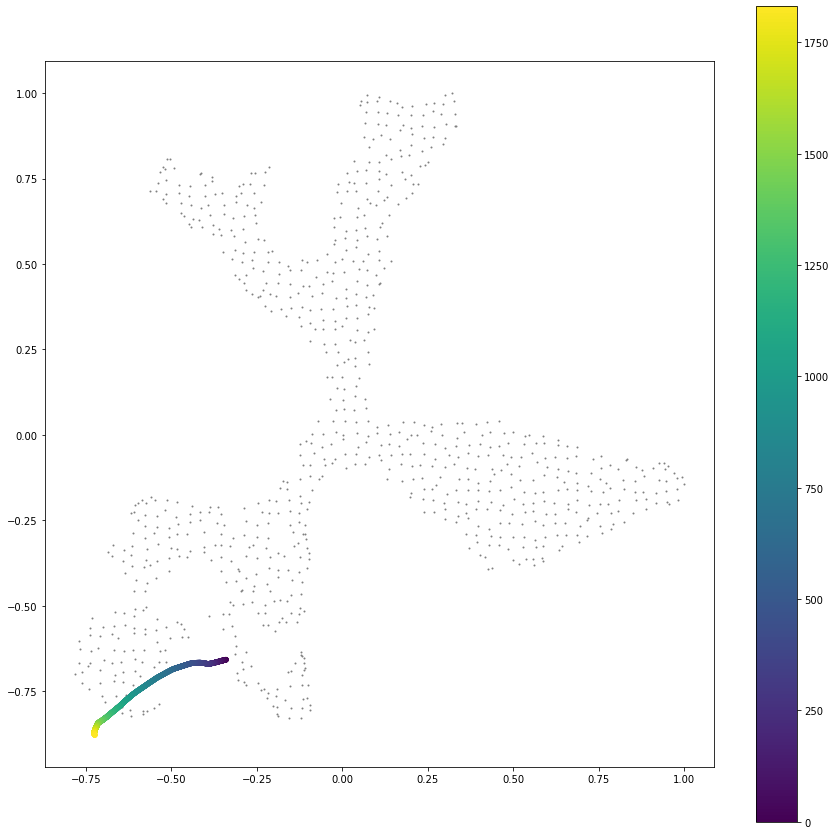

In [183]:
traj = diffusion(embedding_downsampling.to_numpy(),velocity_embedding, 582, 0.001, 2000, 100)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))
ax.set_aspect('equal', adjustable='box')

plt.colorbar()

yikes
velocity at  [-0.22806139 -0.91409507] is too small
trajectory stopped at time step:  1347


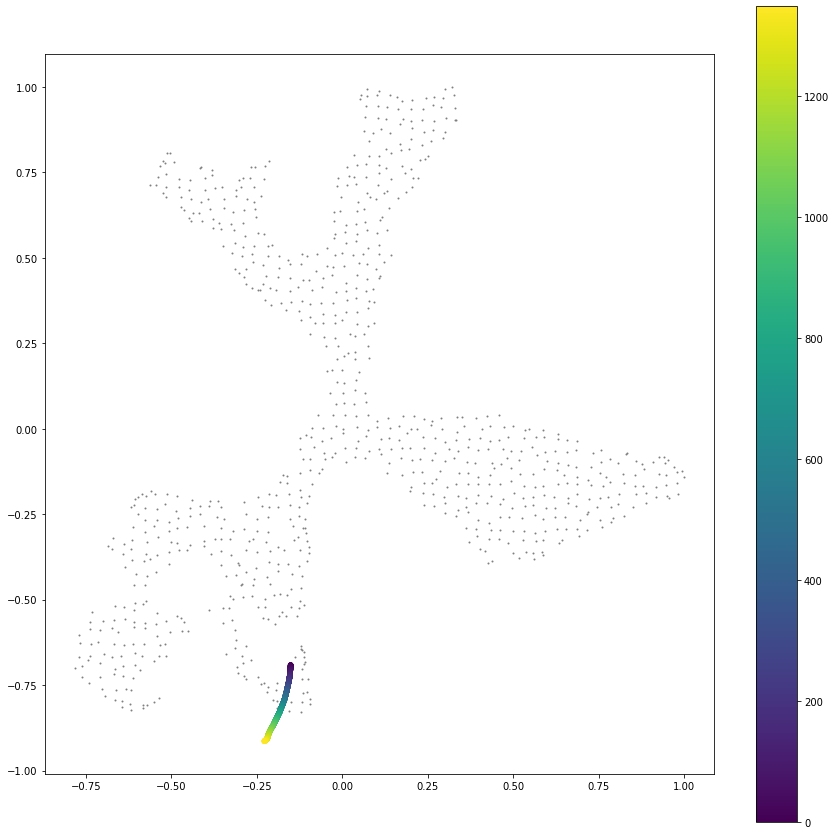

In [186]:
traj = diffusion(embedding_downsampling.to_numpy(),velocity_embedding, 250, 0.001, 2000, 100)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], s=20, c=range(len(traj)))
ax.set_aspect('equal', adjustable='box')

plt.colorbar()

In [716]:
xmin = (-1, -1)
xmax = (1, 1)
x_range = np.array(xmax) - np.array(xmin)
steps = (30, 30)

def discretize(coordinate):
    grid_coor = np.int64(np.floor((coordinate-xmin)/(x_range/steps)))
    return grid_coor

def generate_grid(cell_embedding, velocity_embedding):

    
    cell_grid = np.int64(np.floor((cell_embedding-xmin)/(x_range/steps)))
    
    mesh = np.zeros((steps[0]+1, steps[1]+1, 2))

    cnt = np.zeros((steps[0]+1, steps[1]+1))
    for index in range(cell_grid.shape[0]):
        #print(index)
        i,j = cell_grid[index]
        mesh[i,j] += velocity[index]
        cnt[i,j] += 1

    for i in range(steps[0]):
        for j in range(steps[1]):
            if cnt[i,j]:
                #print(cnt[i,j], "in cell ", i, j)
                mesh[i,j] /= cnt[i,j]
    
    return mesh


vel_mesh = generate_grid(cell_embedding, velocity)

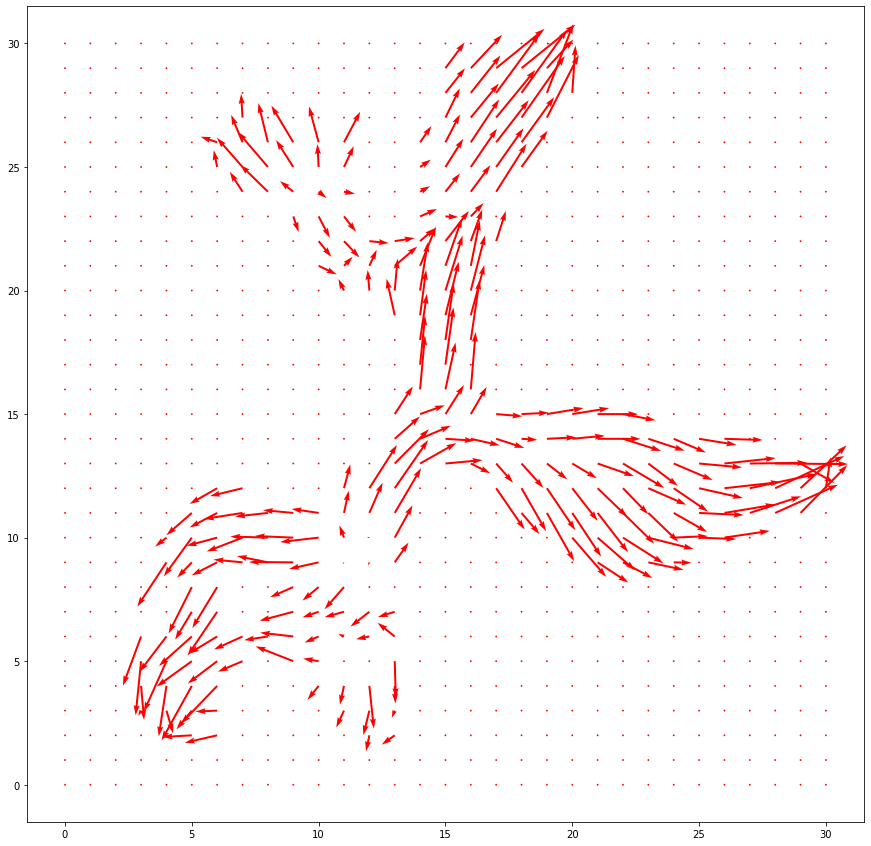

In [717]:
def plot_mesh(mesh):
    x=list()
    y=list()
    vx=list()
    vy=list()
    for i in range(mesh.shape[0]):
        for j in range(mesh.shape[1]):
            x.append(i)
            y.append(j)
            vx.append(mesh[i,j][0])
            vy.append(mesh[i,j][1])
    plt.quiver(x,y,vx,vy,color='red',scale =10)

plot_mesh(vel_mesh)

In [727]:
def diffusion_on_grid2(cell_embedding, vel, init, dt, timestep):
    
    
    '''
    Simulation of diffusion of cells in the velocity field
    - velocity of each grid cell is already assigned
    - init is the initial position (cell_embedding)
    - dt is time step
    - timestep is total number of time steps
    - eps is the criterion to stop a trajectory before timestep (v_net < eps)
    '''
    
    x0 = cell_embedding[init]
    x0_d = discretize(x0)
    v0 = vel[x0_d[0],x0_d[1]]
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < 1e-5:
        return trajectory
    
    for i in range(timestep):
        x = x0 + v0*dt
        x_d = discretize(x)
        try:
            v = vel[x_d[0],x_d[1]]
        except IndexError:
            break
        
        if np.linalg.norm(v) < 1e-5:
        # consider whether a near grid has velocity
            x0_d = discretize(x0)
            x_1 = np.array([x0[0], x[1]])
            x_2 = np.array([x[0], x0[1]])
            
            v_1 = vel[x0_d[0], x_d[1]]
            v_2 = vel[x_d[0], x0_d[1]]
            
            if np.linalg.norm(v_1)+np.linalg.norm(v_2) < 1e-5:
                trajectory.append(x)
                break
            else:
                x, v = (x_1,v_1) if np.linalg.norm(v_1) > np.linalg.norm(v_2) else (x_2,v_2)
                
        trajectory.append(x)
        x0 = x
        v0 = v

    return trajectory

In [723]:
def diffusion_on_grid(cell_embedding, vel, init, dt, timestep):
    
    
    '''
    Simulation of diffusion of cells in the velocity field
    - velocity of each grid cell is already assigned
    - init is the initial position (cell_embedding)
    - dt is time step
    - timestep is total number of time steps
    - eps is the criterion to stop a trajectory before timestep (v_net < eps)
    '''
    
    x0 = cell_embedding[init]
    x0_d = discretize(x0)
    v0 = vel[x0_d[0],x0_d[1]]
    trajectory = [x0]
    
    # trivial cases starting from a destination.
    if np.linalg.norm(v0) < 1e-5:
        return trajectory
    
    for i in range(timestep):
        x = x0 + v0*dt
        x_d = discretize(x)
        try:
            v = vel[x_d[0],x_d[1]]
        except IndexError:
            break
        
        if np.linalg.norm(v) < 1e-5:
        # consider whether a near grid has velocity
            break
        trajectory.append(x)
        x0 = x
        v0 = v

    return trajectory

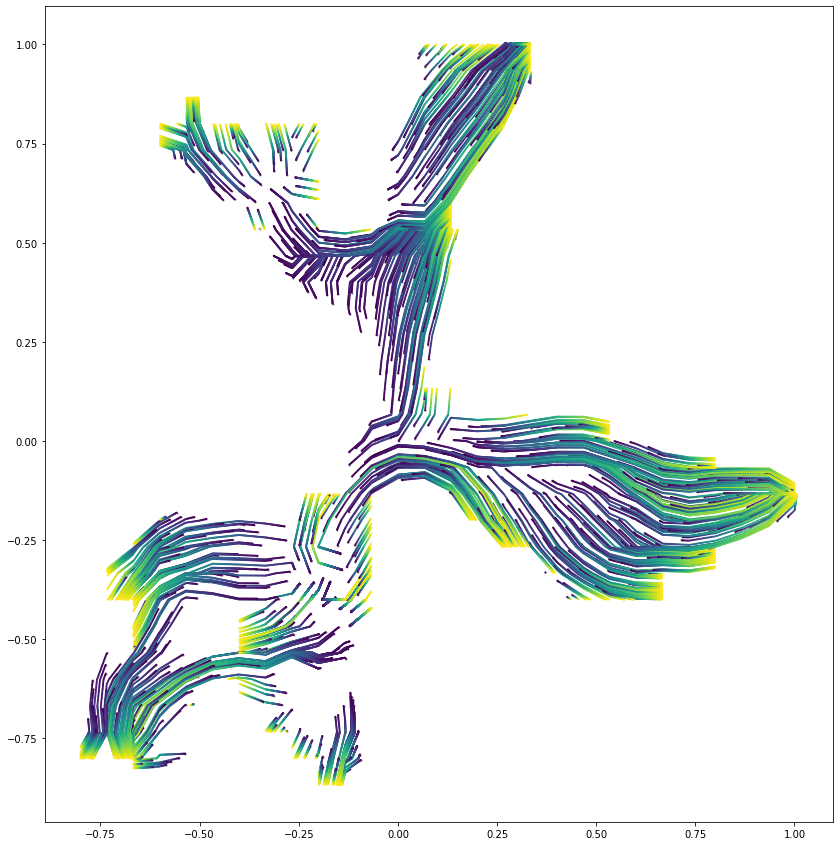

In [730]:
traj = list()
for i in range(891):
    traj.append(diffusion_on_grid(embedding_downsampling.to_numpy(),vel_mesh, i, 0.005, 5000))

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj:
    plt.scatter(np.array(i)[:,0], np.array(i)[:,1], s=1, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')

plt.show()

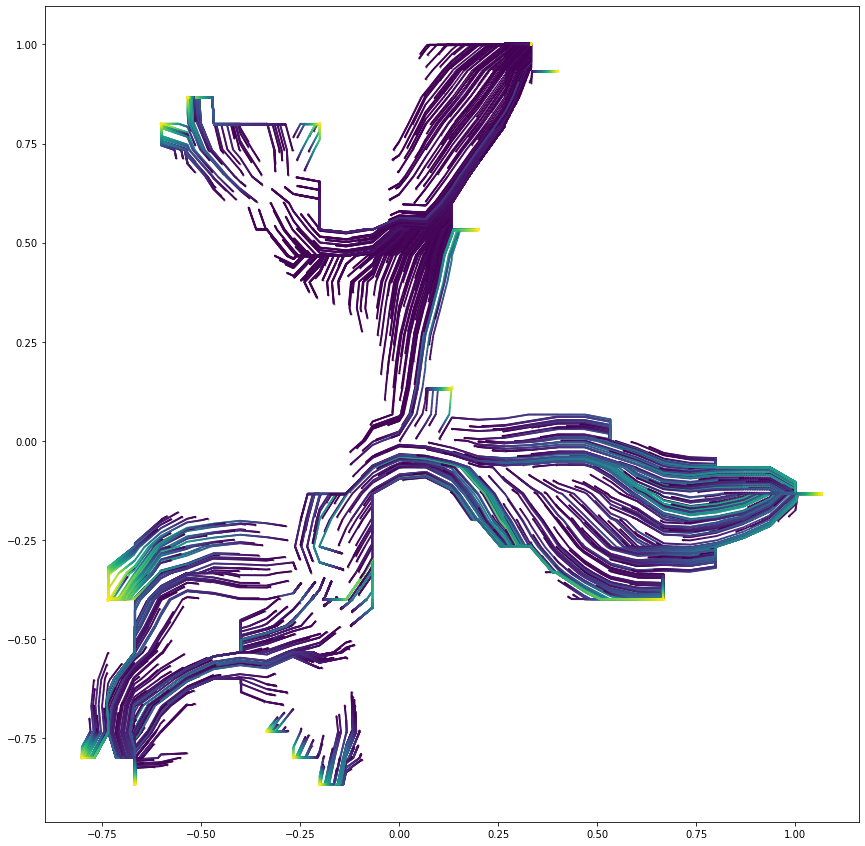

In [732]:
traj2 = list()
for i in range(891):
    traj2.append(diffusion_on_grid2(embedding_downsampling.to_numpy(),vel_mesh, i, 0.005, 5000))

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj2:
    plt.scatter(np.array(i)[:,0], np.array(i)[:,1], s=1, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')

plt.show()

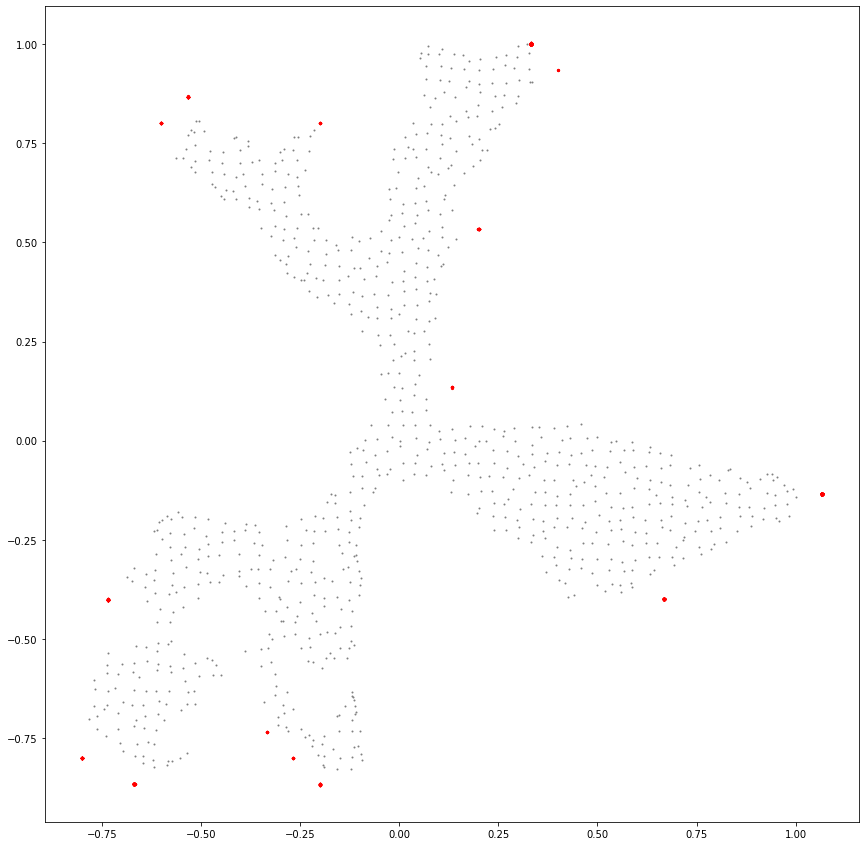

In [733]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj2:
    plt.scatter(np.array(i)[-1,0], np.array(i)[-1:,1], s=5, c='red')
    ax.set_aspect('equal', adjustable='box')

plt.show()

In [710]:
# vel_mesh interpolation/extrapolation.

x = np.arange(0,steps[0]+1,1)
y = np.arange(0,steps[1]+1,1)
X, Y = np.meshgrid(x,y)

sx = list()
sy = list()
vx = list()
vy = list()

for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        if np.linalg.norm(vel_mesh[i,j]) > 0:
            sx.append(i)
            sy.append(j)
            vx.append(vel_mesh[i,j][0])
            vy.append(vel_mesh[i,j][1])
points = np.transpose(np.vstack((sx, sy)))

vx_interp = interpolate.griddata(points, vx, (X, Y), method='linear')
vy_interp = interpolate.griddata(points, vy, (X, Y), method='linear')

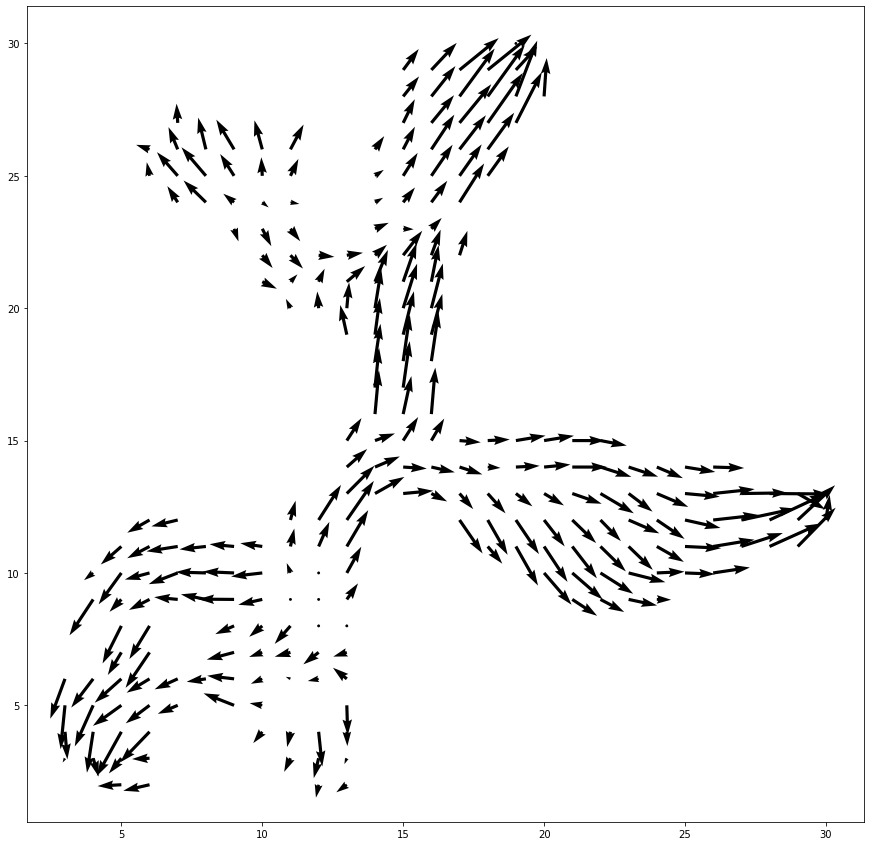

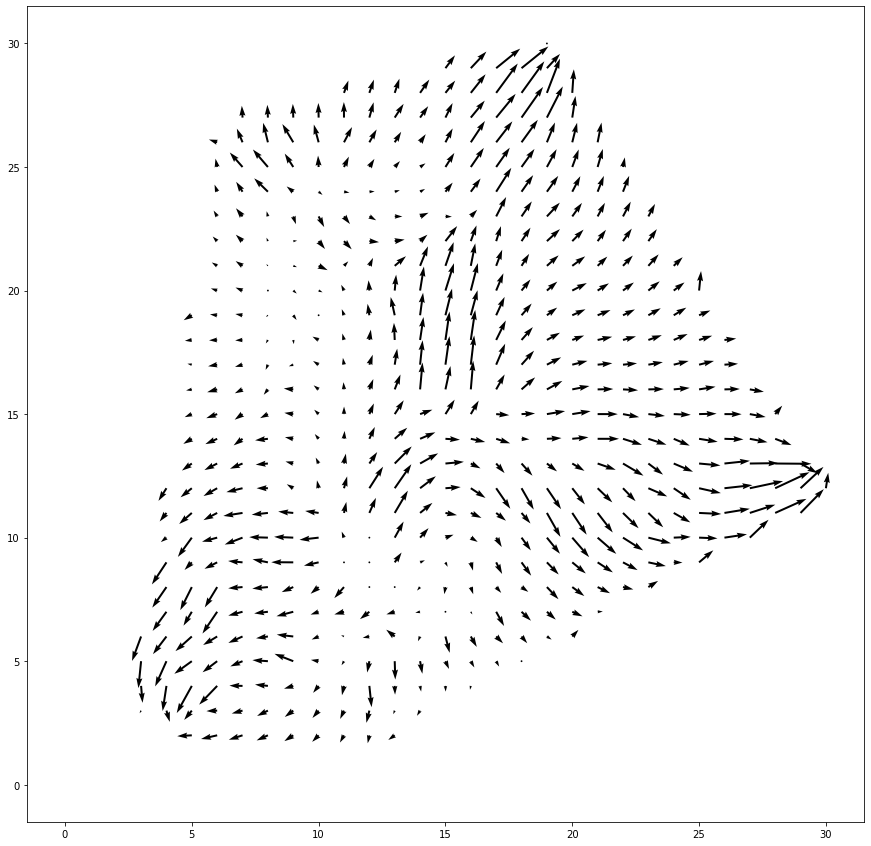

In [687]:
plt.figure(1)
plt.quiver(sx, sy, vx, vy)
plt.figure(2)
plt.quiver(X, Y, vx_interp, vy_interp)
plt.show()

In [688]:
for i in range(vel_mesh.shape[0]):
    for j in range(vel_mesh.shape[1]):
        vel_mesh[i,j]=np.array([vx_interp[i,j],vy_interp[i,j]])

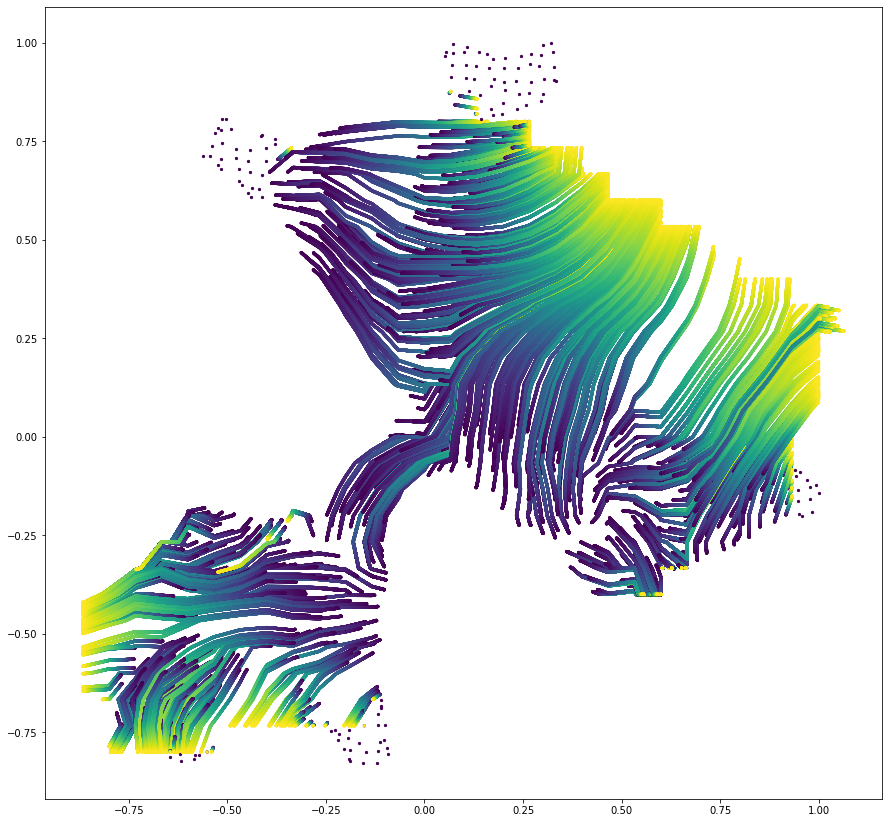

In [691]:
traj3 = list()


a = np.nan_to_num(vel_mesh)
for i in range(891):
    traj3.append(diffusion_on_grid(embedding_downsampling.to_numpy(),a, i, 0.0005, 5000))

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)

for i in traj3:
    plt.scatter(np.array(i)[:,0], np.array(i)[:,1], s=5, c=range(len(i)))
    ax.set_aspect('equal', adjustable='box')



plt.show()

In [819]:
def compute_trajectory_length (traj):
    traj = np.array(traj)
    
    temp = traj[:-1,:] - traj[1:,:]
    
    length = 0
    for i in temp:
        length += np.linalg.norm(i)
    return length

traj_lengths = [trajectory_length(i) for i in traj]

In [853]:
def compute_trajectory_similarity (traj1, traj2):
    '''
    Computes the similarity between two curves based on average distance of a selection of closest pairs

    Input: two list of coordinates of points along the curves
    Return: a float number
    '''
    
    #plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
    #plt.scatter(np.array(traj1)[:,0], np.array(traj1)[:,1], s=5, c=range(len(traj1)))
    #plt.scatter(np.array(traj2)[:,0], np.array(traj2)[:,1], s=5, c=range(len(traj2)))
    #plt.show()


    # let traj1 always be the longer one
    length1,length2 = compute_trajectory_length(traj1), compute_trajectory_length(traj2)
    traj1, traj2 = (traj2, traj1) if length1 < length2 else (traj1, traj2)
    

    
    # pick N points evenly from traj2
    N = 10
    T = len(traj2)
    
    traj1 = np.array(traj1)
    dissimilar = 0.
    for i in range(N):
        pickedPoints = i*int(T/N)
        
        idist=traj1-traj2[pickedPoints]
        dissimilar += min(np.sum(idist**2,axis=1)**(1./2))
    dissimilar /= N
    
    return dissimilar

In [854]:
def compute_similarity_matrix(traj):
    ncells = len(traj)
    simMat = np.zeros((ncells,ncells))
    for i in range(ncells):
        for j in range(i, ncells):
            simMat[i,j]=compute_trajectory_similarity(traj[i], traj[j])
            simMat[j,i]=simMat[i,j]
    return simMat
            

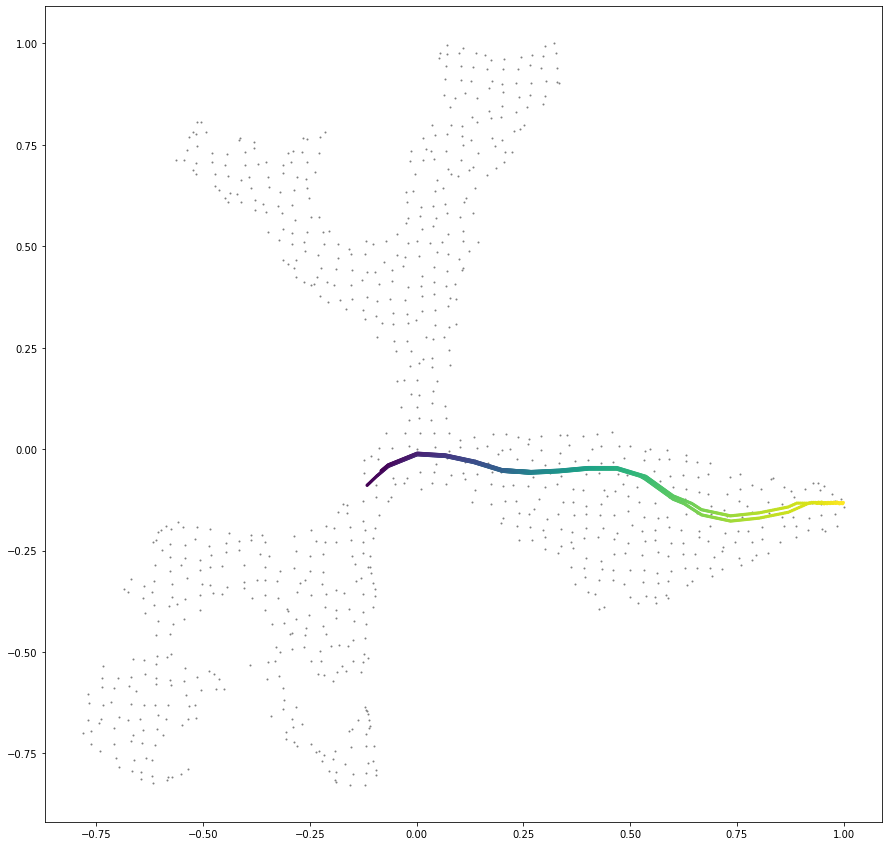

0.005556613642583485

In [812]:
trajectory_similarity(traj[95], traj[316])

In [819]:
def __compute_trajectory_length (traj):
    traj = np.array(traj)
    
    temp = traj[:-1,:] - traj[1:,:]
    
    length = 0
    for i in temp:
        length += np.linalg.norm(i)
    return length

traj_lengths = [trajectory_length(i) for i in traj]

def __compute_trajectory_similarity (traj1, traj2):
    '''
    Computes the similarity between two curves based on average distance of a selection of closest pairs

    Input: two list of coordinates of points along the curves
    Return: a float number
    '''
    
    #plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
    #plt.scatter(np.array(traj1)[:,0], np.array(traj1)[:,1], s=5, c=range(len(traj1)))
    #plt.scatter(np.array(traj2)[:,0], np.array(traj2)[:,1], s=5, c=range(len(traj2)))
    #plt.show()


    # let traj1 always be the longer one
    length1,length2 = __compute_trajectory_length(traj1), compute_trajectory_length(traj2)
    traj1, traj2 = (traj2, traj1) if length1 < length2 else (traj1, traj2)
    

    
    # pick N points evenly from traj2
    N = 10
    T = len(traj2)
    
    traj1 = np.array(traj1)
    dissimilar = 0.
    for i in range(N):
        pickedPoints = i*int(T/N)
        
        idist=traj1-traj2[pickedPoints]
        dissimilar += min(np.sum(idist**2,axis=1)**(1./2))
    dissimilar /= N
    
    return dissimilar

def __compute_similarity_matrix(traj):
    ncells = len(traj)
    simMat = np.zeros((ncells,ncells))
    for i in range(ncells):
        for j in range(i, ncells):
            simMat[i,j]=__compute_trajectory_similarity(traj[i], traj[j])
            simMat[j,i]=simMat[i,j]
    return simMat
            

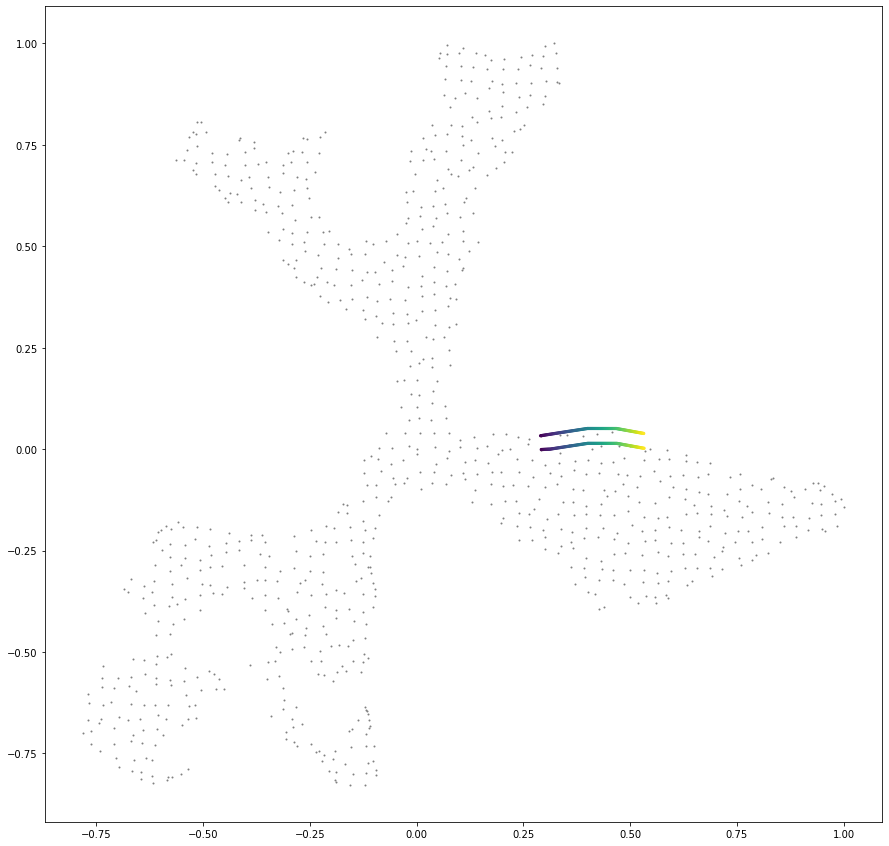

0.036033776260398234

In [814]:
trajectory_similarity(traj[2],traj[3])

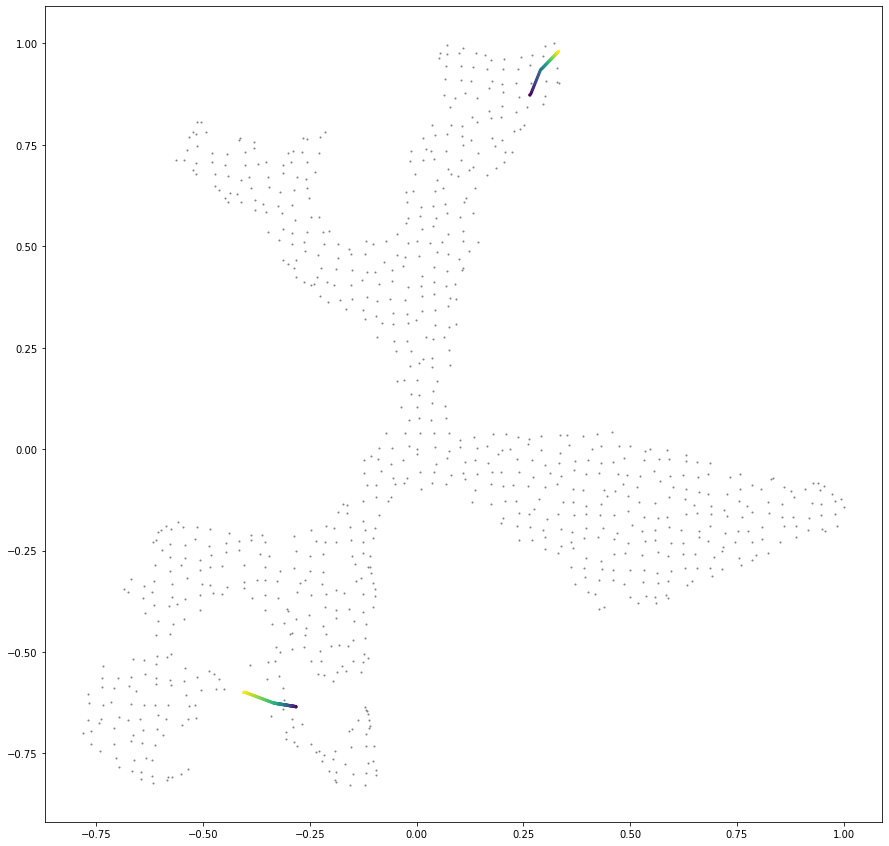

1.6102266662397657

In [815]:
trajectory_similarity(traj[333],traj[658])

In [855]:
similarity_matrix = compute_similarity_matrix(traj)

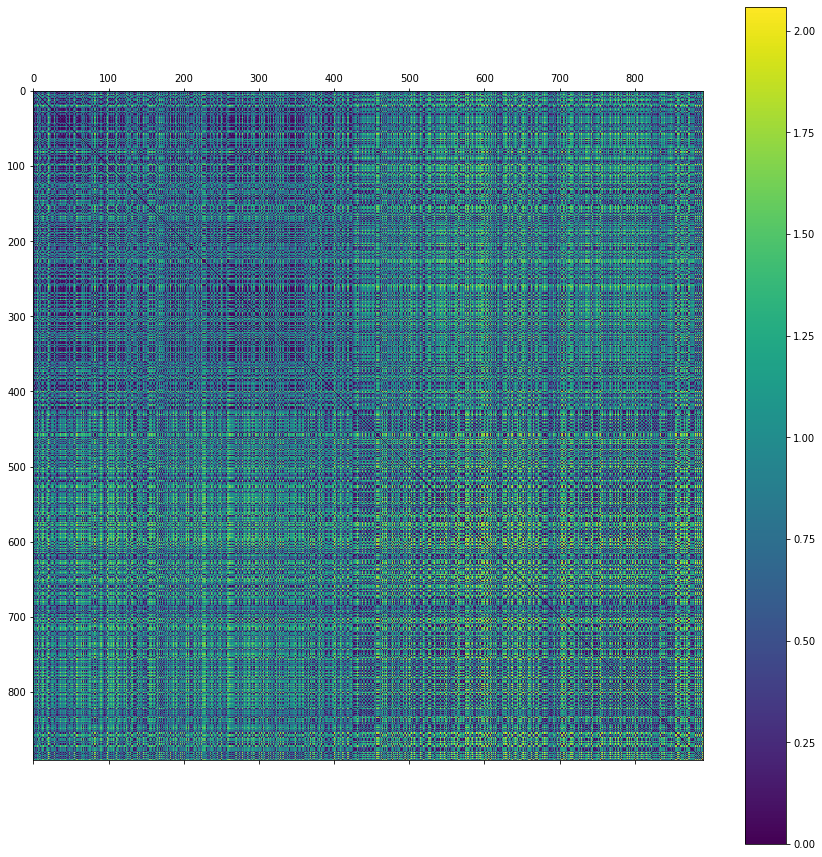

In [861]:
plt.matshow(similarity_matrix)
plt.colorbar()

In [859]:
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [1054]:
def plot_trajs(trj_list, cluster):
    plt.scatter(embedding_downsampling.embedding1, embedding_downsampling.embedding2, c='gray', s=1)
    for i in trj_list:
        plt.scatter(np.array(traj[i])[:,0], np.array(traj[i])[:,1], s=5, c=range(len(traj[i])))
        plt.axis('off')
    plt.savefig('EMG {0}.png'.format(cluster))
    plt.show()

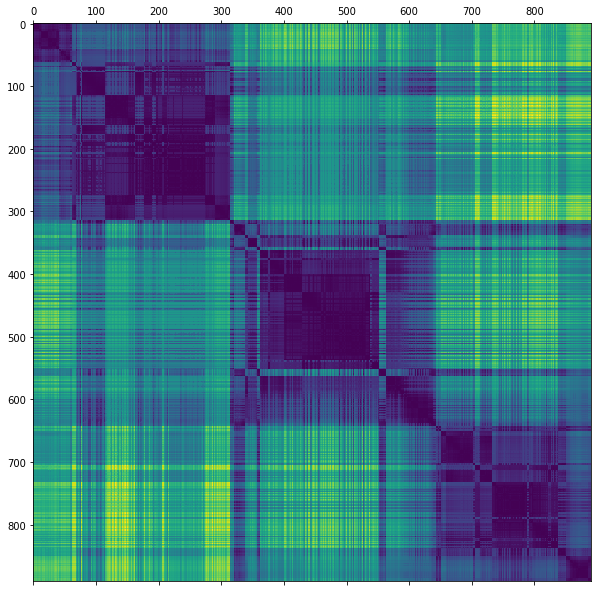

In [1006]:
from scipy.spatial.distance import squareform
from fastcluster import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster



dist_mat = similarity_matrix

N = dist_mat.shape[0]

ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat,'single')

plt.rcParams['figure.figsize']=(10,10)
plt.matshow(ordered_dist_mat)
plt.show()

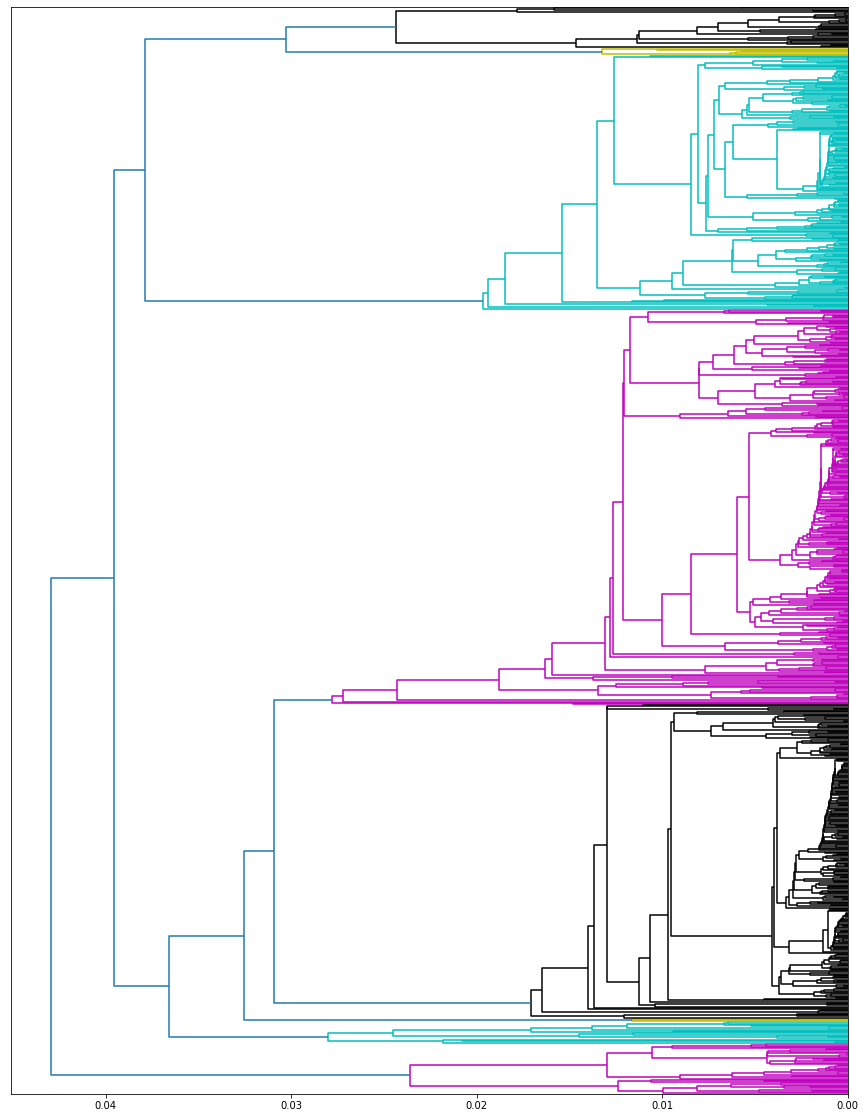

In [1045]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])

plt.rcParams['figure.figsize']=(15,20)

labelList = list(range(7))
dn = dendrogram(res_linkage, 
                orientation='left',
                no_labels=True,
               show_leaf_counts=True)

hierarchy.set_link_color_palette(None)

plt.show()

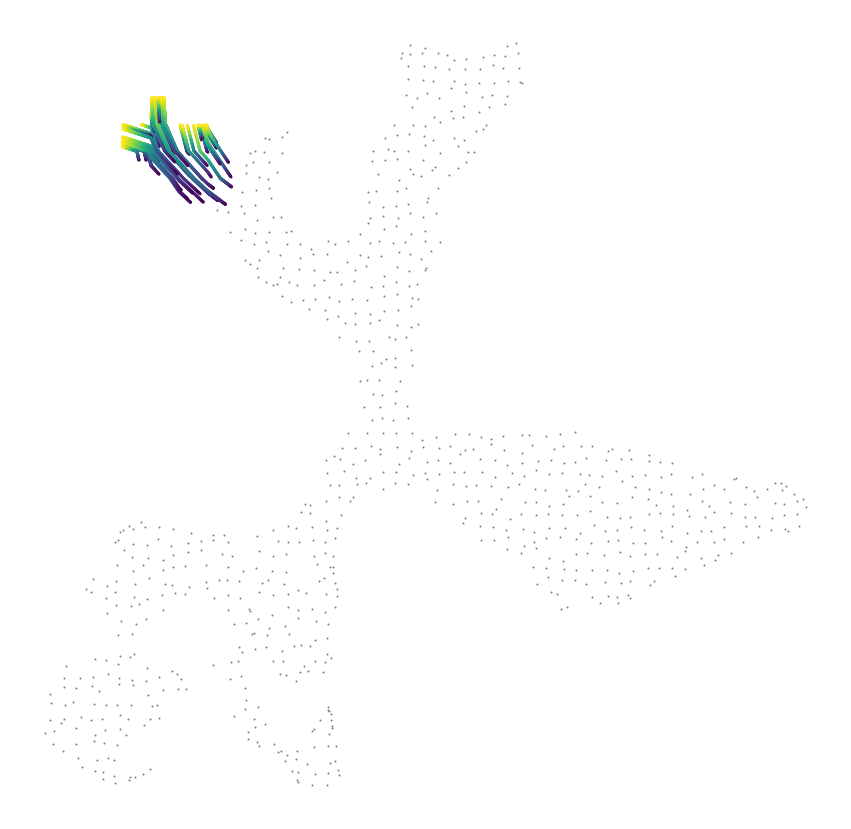

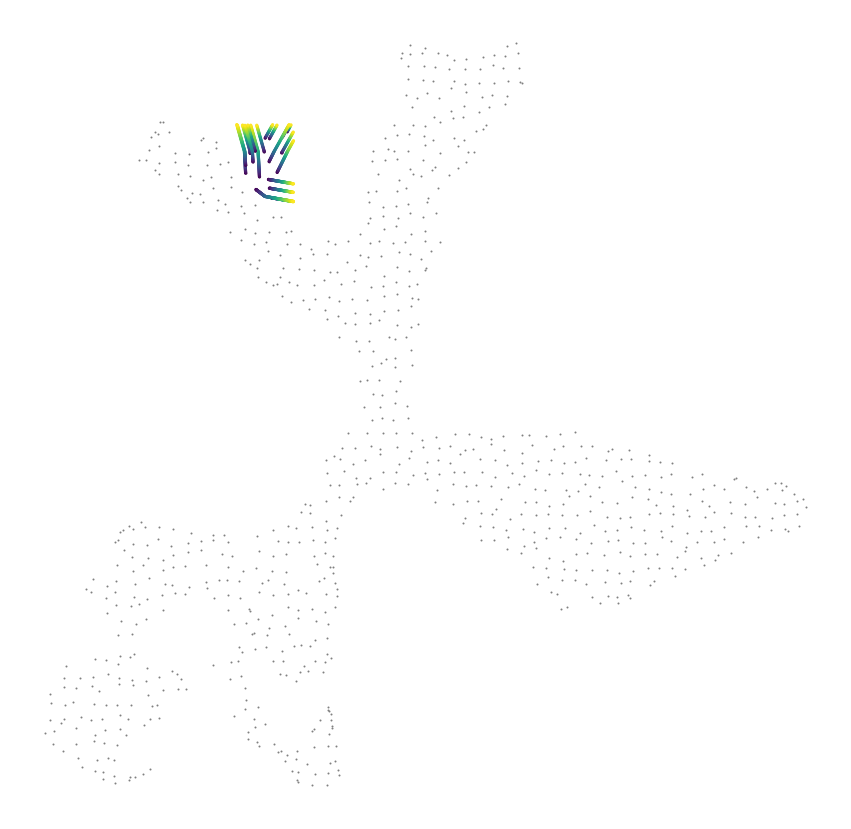

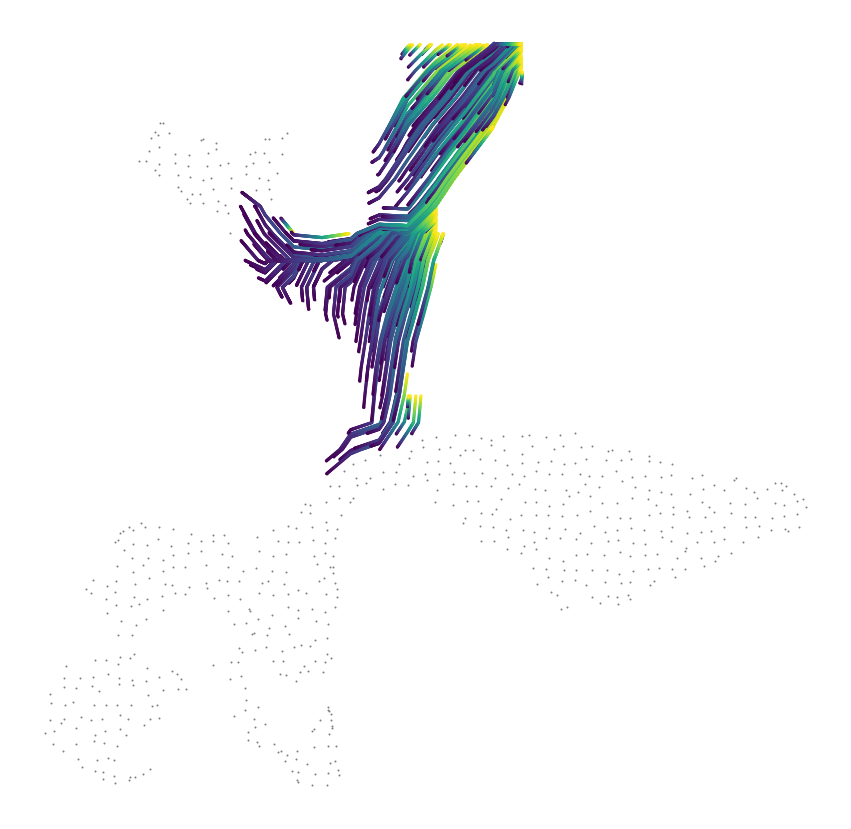

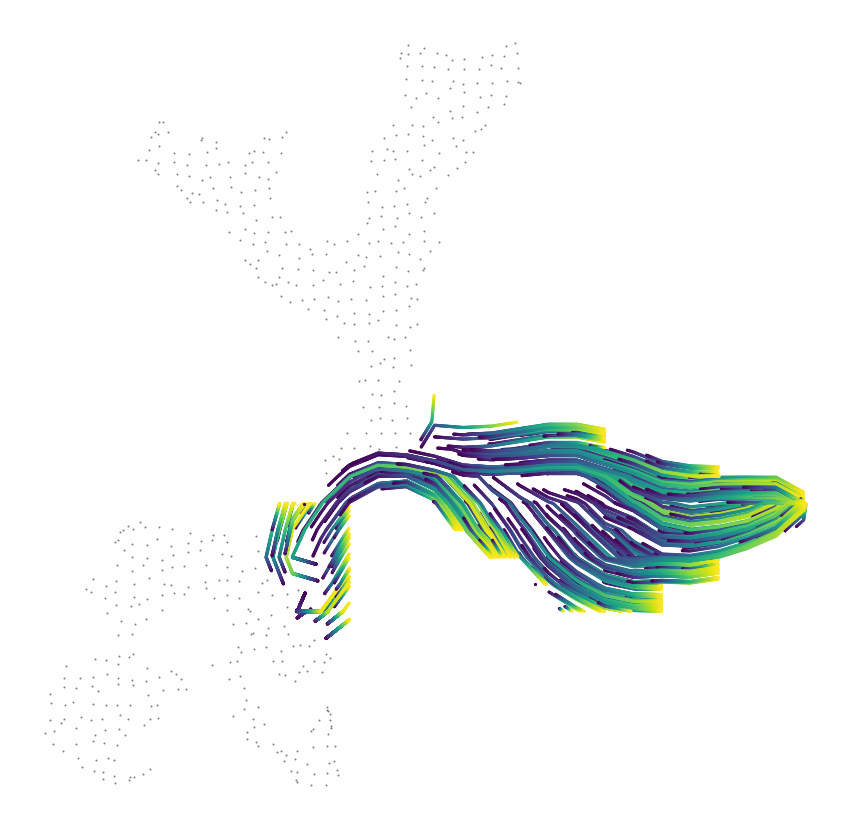

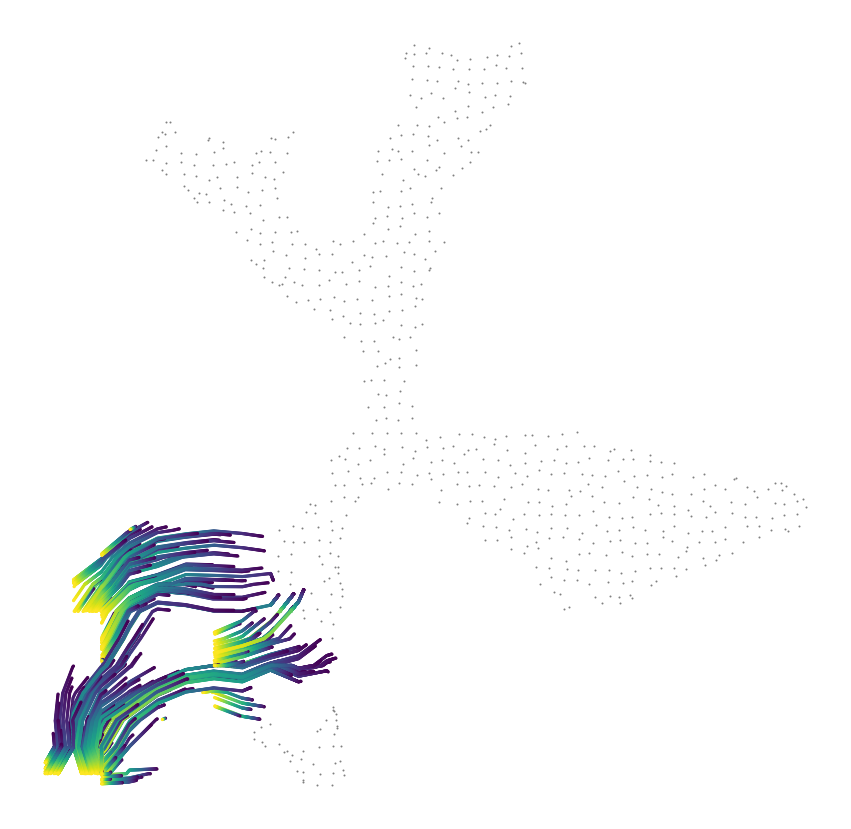

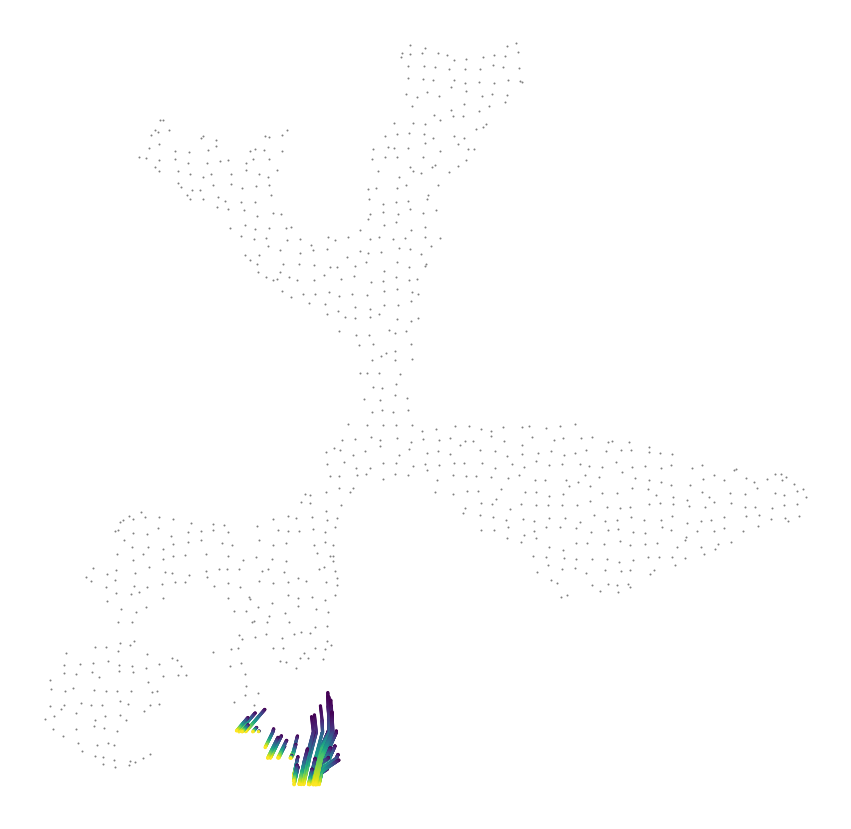

In [1055]:
plt.rcParams['figure.figsize']=(15,15)

nclusters = 7
traj_threshold = 10

cluster_label = fcluster(res_linkage, t=nclusters, criterion='maxclust')

for i in range(nclusters):
    cluster = np.where(cluster_label == i+1)[0].tolist()
    if len(cluster) < traj_threshold:
        continue
    plot_trajs(cluster, i+1)
plt.show()

In [1141]:
def compute_dtw(traj1, traj2, radius=1):
    '''
    Computes the similarity between two curves using dtw

    Input: two list of coordinates of points along the curves
    Return: a float number
    '''
    
    traj1 = np.array(traj1)
    traj2 = np.array(traj2)
    
    distance, path = fastdtw(traj1, traj2, radius)
    
    return distance

def compute_dtw_matrix(traj):
    ncells = len(traj)
    simMat = np.zeros((ncells,ncells))
    for i in range(ncells):
        for j in range(i, ncells):
            simMat[i,j]=compute_dtw(traj[i], traj[j])
            simMat[j,i]=simMat[i,j]
    return simMat
            

dtw_matrix = compute_dtw_matrix(traj)

In [1144]:
!pip install dtw-python

     |████████████████████████████████| 309 kB 3.5 MB/s eta 0:00:01


In [1145]:
from dtw import *
alignment = dtw(np.array(traj[2]), np.array(traj[3]), keep_internals=True, open_begin=)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [1149]:
help(dtw)

Help on function dtw in module dtw.dtw:

dtw(x, y=None, dist_method='euclidean', step_pattern='symmetric2', window_type=None, window_args={}, keep_internals=False, distance_only=False, open_end=False, open_begin=False)
    Compute Dynamic Time Warp and find optimal alignment between two time
    series.
    
    **Details**
    
    The function performs Dynamic Time Warp (DTW) and computes the optimal
    alignment between two time series ``x`` and ``y``, given as numeric
    vectors. The “optimal” alignment minimizes the sum of distances between
    aligned elements. Lengths of ``x`` and ``y`` may differ.
    
    The local distance between elements of ``x`` (query) and ``y``
    (reference) can be computed in one of the following ways:
    
    1. if ``dist_method`` is a string, ``x`` and ``y`` are passed to the
       `scipy.spatial.distance.cdist` function with the method given;
    2. multivariate time series and arbitrary distance metrics can be
       handled by supplying a loc

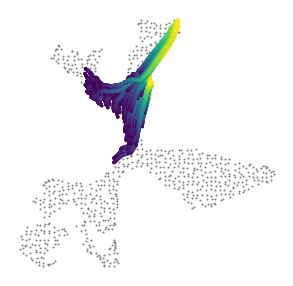

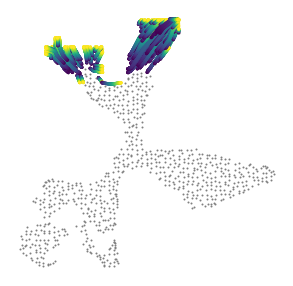

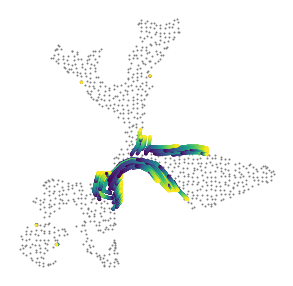

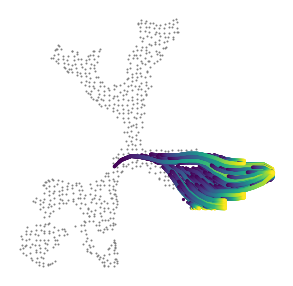

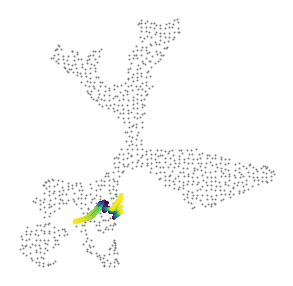

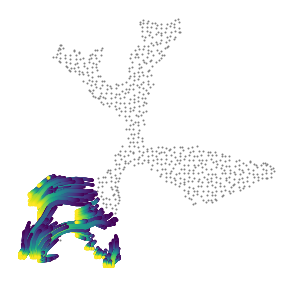

In [1139]:

N = dtw_matrix.shape[0]

flat_dist_mat = squareform(dtw_matrix)
dtw_res_linkage = linkage(flat_dist_mat, method='ward', preserve_input=False)

plt.rcParams['figure.figsize']=(5,5)

nclusters = 6
traj_threshold = 0

cluster_label = fcluster(dtw_res_linkage, t=nclusters, criterion='maxclust')

for i in range(nclusters):
    cluster = np.where(cluster_label == i+1)[0].tolist()
    if len(cluster) < traj_threshold:
        continue
    plot_trajs(cluster, i+1)
plt.show()

In [1123]:
cluster_label = fcluster(dtw_res_linkage, t=2)

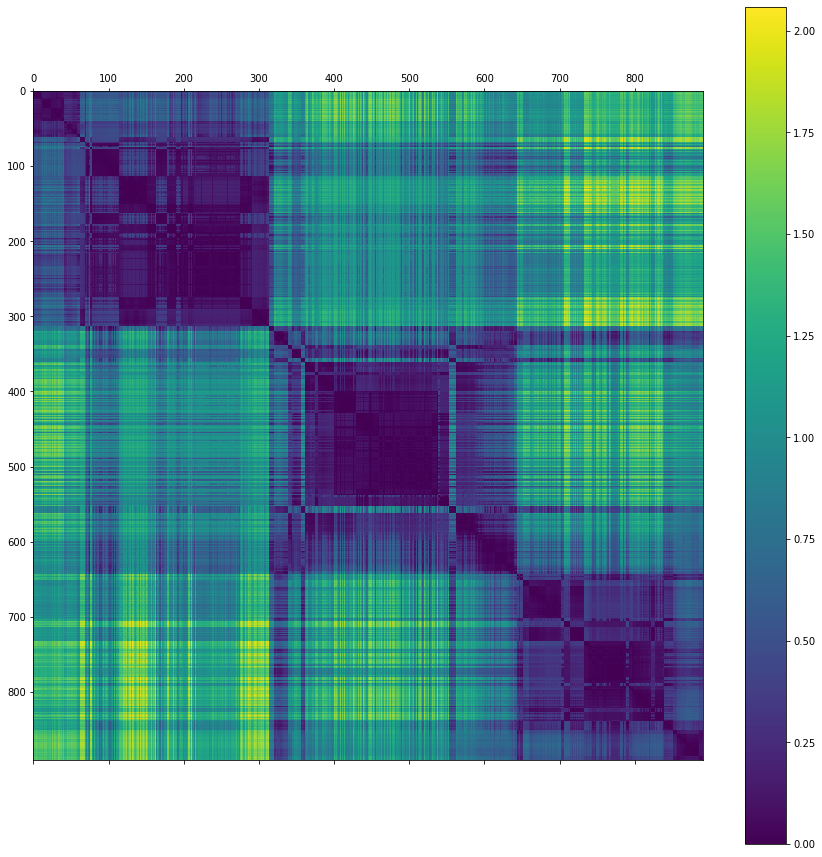

In [1127]:
plt.matshow(dtw_ordered_dist_mat)
plt.colorbar()